In [69]:
import pandas as pd
import numpy as np
import scipy.io as sc
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA 
from pandas.plotting import lag_plot, autocorrelation_plot

In [42]:
#import social factors
soc_df = pd.read_csv("datasets/after/mergedSOC.csv", index_col=0)
print(soc_df.shape)
soc_df.head()

(51, 336)


,00L13,01L13,02L13,03L13,04L13,05L13,06L13,07L13,08L13,09L13,...,38L19,39L19,40L19,41L19,42L19,43L19,44L19,45L19,46L19,47L19
county,,,,,,,,,,,,,,,,,,,,,
Angelina,8.8,6.8,48.6,19.6,16.3,7.4,14.5,29.6,26.6,6.1,...,28.7,55.5,1.3,3.6,10.9,23.0,51.3,2.9,6.8,16.0
Bastrop,3.1,8.3,50.9,20.1,17.6,10.3,10.1,31.0,24.5,6.6,...,36.0,47.3,1.1,2.2,13.5,27.4,43.3,1.0,11.3,17.0
Bell,5.6,5.5,41.7,16.9,30.3,4.4,4.1,30.2,28.3,10.2,...,33.7,51.8,2.4,2.3,9.8,31.6,45.4,2.1,7.7,13.2
Bexar,6.0,4.9,40.8,20.2,28.0,7.9,8.4,26.5,23.1,7.4,...,42.5,42.5,2.7,2.2,10.1,35.1,39.9,3.7,7.7,13.6
Bowie,1.8,5.8,49.0,23.7,19.6,2.4,9.7,38.2,25.9,5.1,...,32.7,46.2,2.2,3.8,15.2,25.3,48.8,2.5,10.5,12.9


In [43]:
#import hospital discharge data
hd_df = pd.read_csv("datasets/after/mergedIP.csv", index_col=0)
print(hd_df.shape)
hd_df.head()

(51, 28)


,1q13,2q13,3q13,4q13,1q14,2q14,3q14,4q14,1q15,2q15,...,3q17,4q17,1q18,2q18,3q18,4q18,1q19,2q19,3q19,4q19
county,,,,,,,,,,,,,,,,,,,,,
Angelina,3.565987,3.940571,3.754997,4.523638,3.707047,3.832749,3.903598,3.949308,3.908970,3.851704,...,4.003234,4.028282,4.154787,4.004243,4.089779,3.665519,4.223953,4.171425,4.397524,4.285616
Bastrop,0.130571,0.113250,0.091933,0.113250,0.098998,0.092309,0.073580,0.084282,0.098926,0.093650,...,0.047432,0.068651,0.062961,0.046010,0.008475,0.047221,0.049654,0.060294,0.043743,0.046107
Bell,3.785636,3.868283,3.815402,3.759353,3.287451,2.735081,2.534750,3.038192,2.975280,4.917622,...,3.887514,4.000583,3.889837,3.843808,3.747061,3.883680,3.748089,3.744923,3.692818,3.652228
Bexar,3.531182,3.486804,3.540411,3.524118,3.482455,3.460764,3.589123,3.596278,3.654202,3.573107,...,3.611293,3.698055,3.703316,3.632400,3.586749,3.685366,3.561545,3.581422,3.651632,3.656333
Bowie,7.351737,6.449875,6.636281,6.277476,6.476405,6.300118,6.694615,6.729012,6.863795,6.842376,...,6.917786,6.644815,6.440529,6.175073,6.398784,6.352757,6.438186,6.459586,6.438186,6.362216


# Autoregression to Predict 2019 Social Factors

### Insert Details

For the first part of our project, we decided to use an autoregressive model to predict social factors in 2019 using the previous years.  We then compared this to the actual social data from 2019.

In [49]:
# mergedSOC_df[[]]
mergedSOC_df = pd.read_csv("datasets/after/mergedSOC.csv", index_col=0)

In [52]:
# factors is an array of dataframes where factors[i] describes the i-th factor.
# For each dataframe, there are 51 rows (number of counties) and 7 columns (number of years)
factors = []
for i in range(0, 48):
    factors.append(mergedSOC_df[[]])

i = 0
for c in mergedSOC_df.columns:
    factors[i] = pd.concat([factors[i], mergedSOC_df.loc[:,c]], axis=1, join='inner')
    factors[i] = factors[i].rename(columns={c: c[-2:]})
    i = (i + 1) % 48


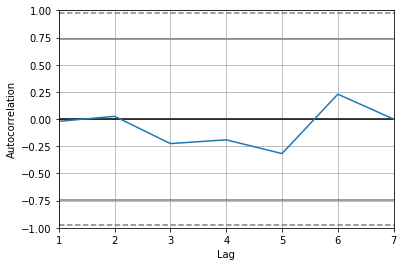

In [100]:
#check the correlation between lag variables
data =pd.DataFrame(factors[0])
autocorrelation_plot(data.iloc[0])
plt.savefig('lag correlations')
plt.show()

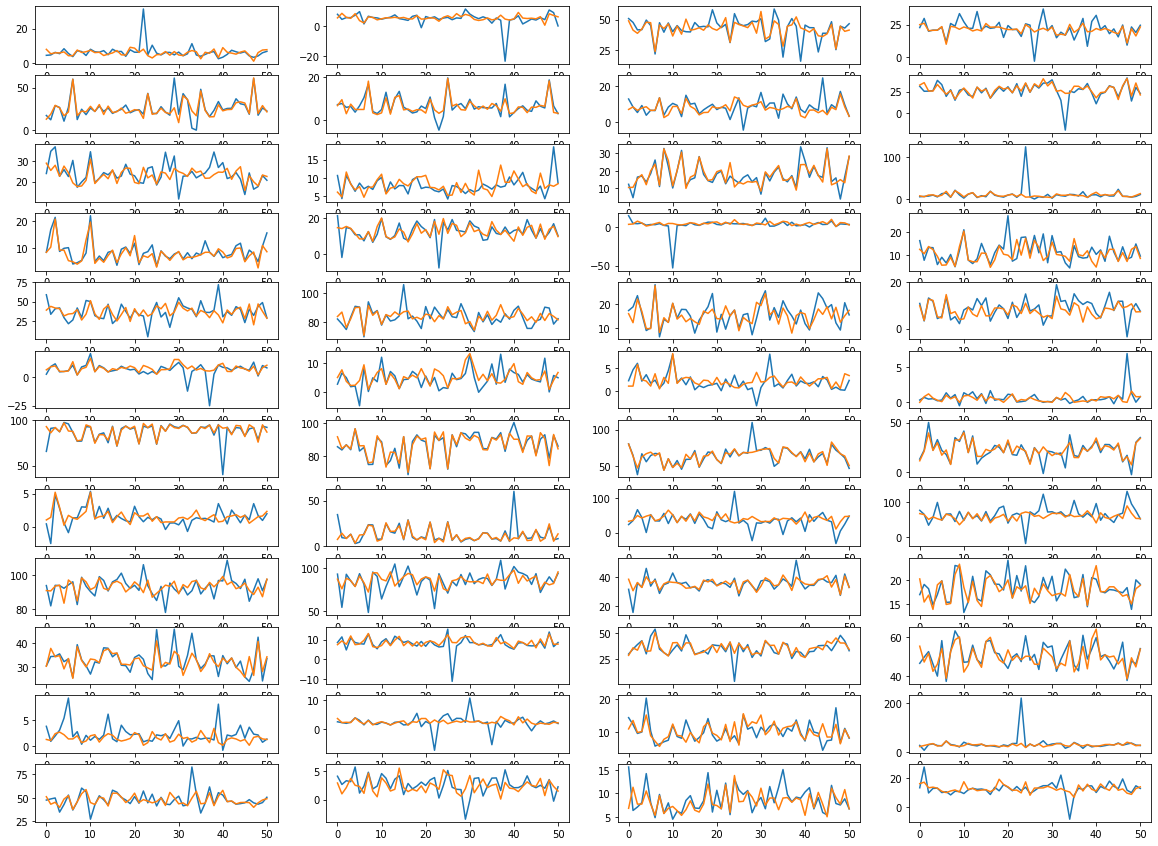

In [103]:
fig, axs = plt.subplots(12, 4, figsize=(20, 15))
row = 0
col = 0
rmsqe = []



for idx in range(48):
    #split test/train data
    test = factors[idx]["19"]
    train = factors[idx].drop("19", axis=1)
    test = np.array(test)
    train = np.array(train)
    predicts = []
    for i in range(51):
        model = AutoReg(train[i], lags = 2)#, old_names=False)
        fit_model = model.fit()
        predict = fit_model.predict(start = len(train[0,:]), end = len(train[0,:]), dynamic = False)
        predicts.append(predict)
        
    predicts = np.array(predicts)
    
    #visualize, calc error
    msqr = 1/len(test)*np.sum(test-predicts)**2
    rmsqr = msqr**(1/2)
    rmsqe.append(rmsqr)
    
    axs[row, col].plot(predicts)
    axs[row, col].plot(test)
    
    
    col = col + 1
    if (col == 4):
        row = row + 1
        col = 0
    # rmsqr

plt.show()

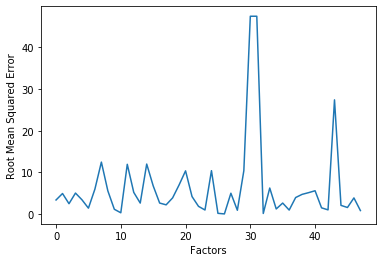

In [105]:
rmesqr = np.array(rmsqe)/51
plt.plot(rmesqr)
plt.xlabel('Factors')
plt.ylabel('Root Mean Squared Error')
plt.savefig('RMSE')
plt.show()